# Fits different RL models for the learning task and compares results with Bayesian model

In [15]:
import os
import numpy as np
from collections import Counter
import matplotlib
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd
import glob
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
import scipy.io as sio
import scipy.stats
from scipy.optimize import minimize
import multiprocessing
import random
from scipy.stats import norm
from scipy.stats import beta
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import pyvttbl as pt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

#R stuff
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
base = importr('base')

%matplotlib inline
sns.set_context("paper")

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Load and Parse Data

In [16]:
sub_list = ['23','24','25','26','27','28','30','31','32','35','36','37','39','40']
home_dir = '/Users/ianballard/Dropbox/rule_learning/'
cond = map(str,range(1,7))
key_map = {30:1,31:0,0:np.NaN,36:np.NaN}
cond_map = {'1':'aandb','2':'aandborc','3':'aorb','4':'a','5':'axorb','6':'aorbandc'}
cond_map2 = {'1':'A and B','2':'(A and B) or C','3':'A or B','4':'A','5':'A xor B','6':'(A or B) and C'}
df = {'hits':[],'sub':[],'condition':[],'true':[],'trial':[],'a':[],'b':[],'c':[],'rt':[]}
correct_answers =  os.path.abspath('correct_answers.mat')
correct_answers = scipy.io.loadmat(correct_answers)

for cond in cond:
    for sub in sub_list:        
        f = os.path.abspath('../behav_data/' + sub + '_rule_learning_' + cond + '.mat')
        f = scipy.io.loadmat(f)
        hits = f['subject_responses'][:,2]
        rt = f['subject_responses'][:,6]*1000
        correct = correct_answers['correct_answers_' + cond_map[cond]].flatten()
        order = f['stim_order']

        df['true'].extend(correct*-1 + 1)
        df['hits'].extend(hits)
        df['rt'].extend(rt)
        df['sub'].extend([sub]*len(hits))
        df['condition'].extend([cond_map2[cond]]*len(hits))
        df['trial'].extend(range(len(hits)))
        df['a'].extend(order[:,0] *-1 + 2)
        df['b'].extend(order[:,1] *-1 + 2)
        df['c'].extend(order[:,2] *-1 + 2)
        
df = pd.DataFrame(df)

#fill in what response must have been
true = df['true'].values.astype(bool)
hit = df['hits'].values
resp = []
for n,t in enumerate(true):
    if hit[n]:
        resp.append(t)
    else:
        resp.append(not t)
resp = np.array(resp).astype(int)
df['resp'] = resp
df['type'] = 'subject'

# plt.figure(figsize=(8, 20))
# g = sns.FacetGrid(df, col='condition',col_wrap = 2, aspect = 3)
# g.map_dataframe(sns.tsplot, time="trial", unit="sub",
#                 value="hits", condition = 'type',color = 'deep').add_legend()
# plt.savefig(home_dir + '/figures/behavior.png',dpi=600)

In [17]:
model_accuracy =  os.path.abspath('model_accuracy.mat')
model_accuracy = scipy.io.loadmat(model_accuracy)
model_accuracy = model_accuracy['model_accuracy']
df2 = {}
df2['hits'] = list(df['hits'].values) + list(model_accuracy.ravel(order='F'))
df2['sub'] =  list(df['sub'].values) + ['model'] * 120
df2['trial'] = list(df['trial'].values) + range(0,20)*6
df2['condition'] = list(df['condition'].values) + list(np.repeat(['A and B','(A and B) or C','A or B','A','A xor B','(A or B) and C'],20))
df2['type'] = list(df['type'].values) + ['model'] * 120

df2 = pd.DataFrame(df2)

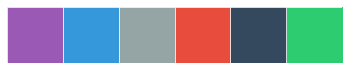

In [18]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.palplot(sns.color_palette(flatui))

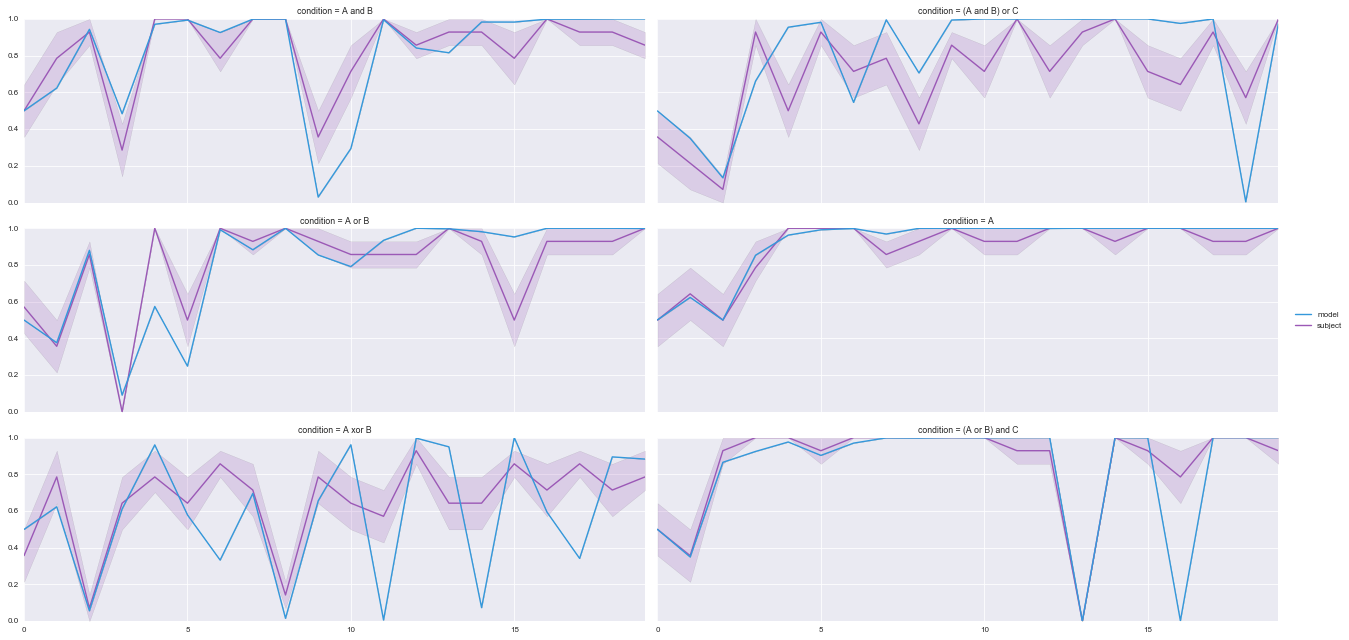

In [5]:
plt.figure(figsize=(8, 20))
g = sns.FacetGrid(df2, col='condition',col_wrap = 2, aspect = 3)
g.map_dataframe(sns.tsplot, time="trial", unit="sub",
                value="hits", condition = 'type',color = sns.color_palette(flatui)).add_legend()

plt.savefig(home_dir + '/figures/model_fits.png',dpi=600)

# Behavioral Analysis

Anova Table (Type 3 tests)

Response: accuracy
     Effect          df  MSE         F ges p.value
1 condition 2.97, 38.60 0.02 10.13 *** .40  <.0001

Sphericity correction method: GG 



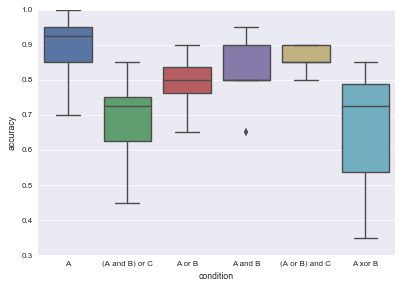

In [128]:
#get accuracy
acc = df.groupby(['condition','sub']).mean()['hits']
acc = acc.unstack(level=0)

acc_df = {'sub':[],'accuracy':[],'condition':[]}
for sub in sub_list:
    for cond in set(df['condition']):
        acc_df['sub'].append(sub)
        acc_df['condition'].append(cond)
        acc_df['accuracy'].append(acc[cond][sub])
acc_df = pd.DataFrame(acc_df)
sns.boxplot(x='condition',y='accuracy',data = acc_df)
plt.savefig('../figures/acc.png',dpi=300)


model = afex.aov_ez('sub', 'accuracy', data = acc_df, within='condition')
print model
# acc_df
lsm  = importr('lsmeans')
pairwise = lsm.lsmeans(model, "condition", contr="pairwise", adjust="holm")
# print pairwise

Anova Table (Type 3 tests)

Response: rt
     Effect          df     MSE      F ges p.value
1 condition 3.66, 47.52 6793.28 3.08 * .02     .03

Sphericity correction method: GG 



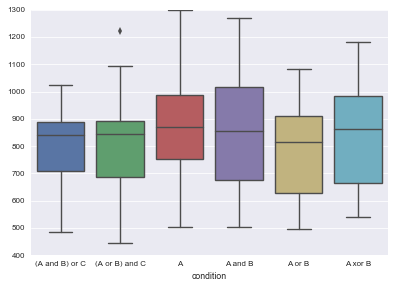

In [126]:
#examine RT
rt = df.groupby(['condition','sub']).mean()['rt']
rt = rt.unstack(level=0)
# print rt.std()

sns.boxplot(rt)
plt.savefig('../figures/rt.png',dpi=300)

no_nan_df = df[np.invert(np.isnan(df['rt']))]
model = afex.aov_ez('sub', 'rt', data = no_nan_df, within='condition')
print model

pairwise = lsm.lsmeans(model, "condition", contr="pairwise", adjust="holm")
# print pairwise

In [136]:
corrs = {'sub':[],'cond':[],'r':[]}
for cond in set(df2['condition']):
    cond_df = df2[df2['condition'] == cond]
    model_acc = cond_df[cond_df['sub'] == 'model']['hits'].values
    for sub in sub_list:
        acc = cond_df[cond_df['sub'] == sub]['hits'].values
        r,p = scipy.stats.pearsonr(acc,model_acc)
        corrs['sub'].append(sub)
        corrs['cond'].append(cond)
        corrs['r'].append(r)
corrs = pd.DataFrame(corrs)
corrs.groupby('cond').mean()

corrs['r_fisher'] = [np.arctanh(x) for x in corrs['r'].values]
for cond in set(df2['condition']):
    r = corrs.loc[corrs['cond'] == cond,'r']
    fish = corrs.loc[corrs['cond'] == cond,'r_fisher']
    fish = fish[np.isfinite(fish)]
    t,p = scipy.stats.ttest_1samp(fish,0)
    
    print cond, np.nanmean(r), p
    

model = afex.aov_ez('sub', 'r_fisher', data = corrs, within='cond')
pairwise = lsm.lsmeans(model, "cond", contr="pairwise", adjust="holm")
print model
# print pairwise

A 0.604308878346 0.000280917487463
(A and B) or C 0.425516327562 0.000141851775959
A or B 0.548850187289 4.21186239316e-07
A and B 0.470631929926 9.74046010349e-05
(A or B) and C 0.638194433046 2.48112904453e-06
A xor B 0.316688895542 0.000966535423611
Anova Table (Type 3 tests)

Response: r_fisher
  Effect          df  MSE      F ges p.value
1   cond 2.68, 26.79 0.22 3.28 * .18     .04

Sphericity correction method: GG 



In [8]:
#get correlation between the model and mean behavior
mean_acc = df.groupby(['condition','trial']).mean()
for cond in set(df2['condition']):
    cond_df = df2[df2['condition'] == cond]

    acc = mean_acc['hits'][cond].values
    model_acc = cond_df[cond_df['sub'] == 'model']['hits'].values
    r,p = scipy.stats.pearsonr(acc,model_acc)
    print r, p, cond

0.967064985399 3.84251599514e-12 A
0.70218348392 0.000557485092524 (A and B) or C
0.822805337809 8.43024014501e-06 A or B
0.84065487999 3.47400544537e-06 A and B
0.83920170359 3.74870453876e-06 (A or B) and C
0.598495068334 0.00530594886514 A xor B


# RL functions

In [93]:
#take the feature values and return a state representation
def state_to_features(state, state_rep):
    if state_rep == 'naive': #one feature per state
        return [tuple(state)]
    
    if state_rep == 'feature': 
        features = []
        for n,s in enumerate(state):
            features.append(str(n) + '_'  + str(s))
        return features
    
    if state_rep == 'exhaustive': #all possible combinations of features
        features = [tuple(state)]
        for n1,s1 in enumerate(state):
            features.append(str(n1) + '_'  + str(s1))
            for n2,s2 in enumerate(state):
                if n1 < n2:
                    features.append( str(n1) + '_'  + str(s1) + '_' +  str(n2) + '_'  + str(s2) )
        return features

In [94]:
#get probability of each action under the softmax
def get_prob(Q,m): 
    probs = map(lambda q: np.exp(q * m), Q)
    probs = probs / np.sum(probs)
    return probs

In [95]:
#return rescorla-wagner update
def update_Q(rew,action,Q,alpha):
    delta = alpha * (rew - Q[action])
    return delta


In [96]:
def get_LL(alpha,m,states,resp,outcomes,true,state_rep,return_LL):

    Q_values = {}
    LL = 0
    deltas = []

    for n,a in enumerate(resp):
        #get q values for features
        features = state_to_features(states[:,n], state_rep)
        Q_state = np.array([0,0])
        for feat in features:
            if feat in Q_values.keys():
                Q = Q_values[feat]
            else: #initialize Q
                Q = np.array([0,0])
                Q_values[feat] = Q
        
            Q_state = Q_state + Q #sum up features

        #get choice probability
        p = get_prob(Q_state,m)[a]
        if p < 1e-200:
            update = np.log(1e-200)
        else:
            update = np.log(p)
        LL += update
        
        #update weights (with the state expectation used in PE)
        delta_Q = update_Q(outcomes[n],a,Q_state,alpha) #get updated Q
        deltas.append(delta_Q)
        for feat in features:
            Q = list(Q_values[feat])
            Q[a] = Q[a] + delta_Q
            Q[1-a] = Q[1-a] - delta_Q #learing is symmetric
            Q_values[feat] = np.array(Q) 
            
    if return_LL:
        return LL
    else:
        return deltas

In [97]:
#compute the likelihood for each subject, summing accross runs
def get_cond_LL(params,sub_data,state_rep):
    alpha = params[0]
    m = params[1]

    cond_LL = {}
    for cond in cond_map2.values():
        c = sub_data[sub_data['condition'] == cond]
        states = np.array([c['a'].values,c['b'].values,c['c'].values])
        resp = c['resp'].values
        outcomes = c['hits'].values *2 -1
        true = c['true'].values *2 -1
        cond_LL[cond] = get_LL(alpha,m,states,resp,outcomes,true,state_rep,True) *-1
            
    return cond_LL

In [98]:
#fit all subjects together with one M
def all_LL(params,state_rep,one_alpha):
    m = params[-1]

    LL =0
    for n,sub in enumerate(sub_list):
        sub_data = df[df['sub'] == sub]
        
        if one_alpha:
            alpha = params[0]
        else:
            alpha = params[n]
        
        for cond in cond_map2.values():
            c = sub_data[sub_data['condition'] == cond]
            states = np.array([c['a'].values,c['b'].values,c['c'].values])
            resp = c['resp'].values
            outcomes = c['hits'].values *2 -1
            true = c['true'].values *2 -1
            LL += get_LL(alpha,m,states,resp,outcomes,true,state_rep,True)

    LL *= -1 #mnimize
    return LL

# Run RL fitting

In [99]:
def run_group(state_rep,one_alpha):
    
    if one_alpha:#fit one m and one alpha
        params = [.2,3]
        bounds = ((0,1),(.01,20))
    else:#fit one m and multiple alphas
        params = [.2]*len(sub_list) + [3]
        bounds = tuple(map(tuple,[[0,1]]*len(sub_list) + [[.01,20]]))
        
    res = minimize(all_LL,params,args=(state_rep,one_alpha),options={'disp': True},bounds = bounds)

    return res

In [100]:
def calc_bic(ll,n_params,n_obs):
    return 2*ll + n_params*np.log(n_obs)

In [101]:
def calc_aicc(ll,n_params,n_obs):
    return 2*ll + 2*n_params + (2*n_params * (n_params+1))/(n_obs*1.0 - n_params -1)

In [133]:
RL_results = {'ll':[],'model':[],'alpha':[],'m':[],'aic':[],'bic':[],'sub':[],'cond':[]}
n_params = 2
ntrials_per_cond = 20
one_alpha = False

for state_rep in ['naive','feature','exhaustive']:
    res = run_group(state_rep,one_alpha)
    
    m = res.x[-1]
    for n,sub in enumerate(sub_list):
        if one_alpha:
            alpha = res.x[0]
        else:
            alpha = res.x[n]
        params = [alpha,m]
        sub_data = df[df['sub'] == sub]
        cond_LL = get_cond_LL(params,sub_data,state_rep)

        for cond in cond_map2.values():
            bic = calc_bic(cond_LL[cond],n_params,ntrials_per_cond)
            aic = calc_aicc(cond_LL[cond],n_params,ntrials_per_cond)
        
            RL_results['ll'].append(cond_LL[cond])
            RL_results['cond'].append(cond)
            RL_results['sub'].append(str(sub))
            RL_results['model'].append(state_rep)
            RL_results['alpha'].append(alpha)
            RL_results['m'].append(m)
            RL_results['aic'].append(aic)
            RL_results['bic'].append(bic)
            
results = pd.DataFrame(RL_results)

In [160]:
results.groupby('model').mean()

,aic,alpha,bic,ll,m
model,,,,,
exhaustive,21.657471,0.115429,22.943053,8.475794,1.633029
feature,25.675265,0.150390,26.960847,10.484691,1.486581
naive,22.993883,0.454946,24.279465,9.144000,2.383872


# Compute the likelihood under the Bayesian Rational Rules Model

In [137]:
model = df2[df2['type'] == 'model']
alpha = .85
ll_df = {'sub':[],'condition':[],'ll':[],'model':[]}

for sub in sub_list:
    sub_df = df[df['sub'] == sub]

    for cond in cond_map2.values():
        cond_df = sub_df[sub_df['condition'] == cond]
        model_cond = model[model['condition'] == cond]
        model_prob = model_cond['hits'].values
        hits = cond_df['hits']
        
        ll = 0
        for n,x in enumerate(hits):
            m_prob = (1-alpha)*.5 + model_prob[n]*alpha
            log_prob = np.log(scipy.stats.bernoulli.pmf(x,m_prob))
            ll += log_prob
        ll_df['sub'].append(sub)
        ll_df['condition'].append(cond)
        ll_df['ll'].append(ll)
        ll_df['model'].append('bayes')
        
ll_df = pd.DataFrame(ll_df)

In [138]:
#combine the RL and Bayesian results into a single data Frame
len_new_data = len(ll_df['condition'].values)

RL_results['cond'].extend(ll_df['condition'].values)
RL_results['sub'].extend(ll_df['sub'].values)
RL_results['ll'].extend(ll_df['ll'].values*-1)
RL_results['model'].extend(['bayes']*len_new_data)
RL_results['alpha'].extend([np.nan]*len_new_data)
RL_results['m'].extend([np.nan]*len_new_data)
RL_results['aic'].extend(map(lambda x: calc_aicc(x,1,20),ll_df['ll'].values*-1))
RL_results['bic'].extend(map(lambda x: calc_bic(x,1,20),ll_df['ll'].values*-1))

RL_results = pd.DataFrame(RL_results)

# Do RFX bayesian model comparison

In [139]:
#write to text file
path = '/Users/ianballard/Dropbox/rule_learning/behav_data/modeling/'
for m in set(RL_results['model'].values):

    if m == 'bayes':
        n_params = 1
    else:
        n_params = 2

    total_ll = RL_results[RL_results['model'] == m].groupby('sub').sum()['ll'].values
    aic = map(lambda x: calc_aicc(x,n_params,120),total_ll)
    bic = map(lambda x: calc_bic(x,n_params,120),total_ll)

    np.savetxt(path + m + '_aic',aic)
    np.savetxt(path + m + '_bic',bic)

In [2]:
%load_ext pymatbridge

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-8613ba2c-4565-4b9e-822c-675723c0023c
Send 'exit' command to kill the server
..........................MATLAB started and connected!


//anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


In [3]:
%%matlab -o pxp_b
path = '/Users/ianballard/Dropbox/rule_learning/behav_data/modeling/';
ic = '_bic';
naive = textread([path,'naive',ic]);
feature = textread([path,'feature',ic]);
exhaustive = textread([path,'exhaustive',ic]);
bayes = textread([path,'bayes',ic]);
lc = [bayes,exhaustive,naive,feature];
%%lc = [bayes,naive,feature];
lc = lc*-1;
[alpha,exp_r,xp,pxp_b,bor] = spm_BMS(lc);

In [4]:
%%matlab -o pxp_a
ic = '_aic';
naive = textread([path,'naive',ic]);
feature = textread([path,'feature',ic]);
exhaustive = textread([path,'exhaustive',ic]);
bayes = textread([path,'bayes',ic]);
lc = [bayes,exhaustive,naive,feature];
%%lc = [bayes,naive,feature];
lc = lc*-1;
[alpha,exp_r,xp,pxp_a,bor] = spm_BMS(lc);

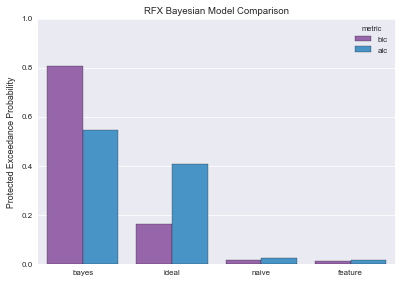

In [10]:
model = ['bayes','ideal','naive','feature']
# model = ['bayes','naive','feature']

xp_df = pd.DataFrame({'model':model*2,
                      'Protected Exceedance Probability':list(pxp_b[0]) + list(pxp_a[0]),
                     'metric':['bic']*len(model) + ['aic']*len(model) })
ax = sns.barplot(x = 'model', y = 'Protected Exceedance Probability',
            hue = 'metric',data = xp_df,palette = sns.color_palette(flatui))
plt.title('RFX Bayesian Model Comparison')
plt.ylabel('Protected Exceedance Probability')
plt.xlabel('')
ax.set_ylim([0,1])
plt.savefig('../figures/model_fit_full.png',dpi=600)

# Now do model comparison within each condition

In [144]:
#write to text file
path = '/Users/ianballard/Dropbox/rule_learning/behav_data/modeling/'
for m in set(RL_results['model'].values):

    if m == 'bayes':
        n_params = 1
    else:
        n_params = 2

    for cond in cond_map2.values():
        cond_res = RL_results[RL_results['cond'] == cond]
        total_ll = cond_res[cond_res['model'] == m]['ll'].values
        aic = map(lambda x: calc_aicc(x,n_params,20),total_ll)
        bic = map(lambda x: calc_bic(x,n_params,20),total_ll)

        np.savetxt(path + m + '_' + cond + '_aic',aic)
        np.savetxt(path + m + '_' + cond + '_bic',bic)

In [48]:
%%matlab -o pxp_b
path = '/Users/ianballard/Dropbox/rule_learning/behav_data/modeling/';
ic = '_aic';
pxp_b = [];
c = {'A and B', 'A or B', '(A and B) or C', 'A xor B', 'A', '(A or B) and C'};

for i=1:6
    naive = textread([path,'naive','_',c{i},ic]);
    feature = textread([path,'feature','_',c{i},ic]);
    exhaustive = textread([path,'exhaustive','_',c{i},ic]);
    bayes = textread([path,'bayes','_',c{i},ic]);
    lc = [bayes,exhaustive,naive,feature];
    lc = lc*-1;
    [alpha,exp_r,xp,pxp,bor] = spm_BMS(lc);
    pxp_b = [pxp_b;pxp];
end

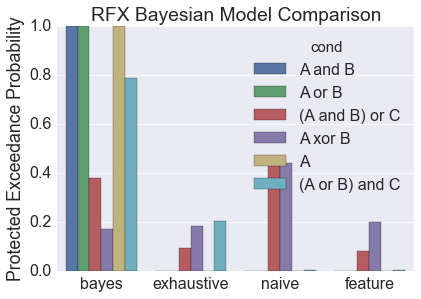

In [49]:
xp_cond_df = {'model':[],'cond':[],'Protected Exceedance Probability':[]}
model = ['bayes','exhaustive','naive','feature']

for n,row in enumerate(pxp_b):
    xp_cond_df['model'].extend(model)
    xp_cond_df['Protected Exceedance Probability'].extend(row)
    xp_cond_df['cond'].extend([cond_map2.values()[n]]*len(model))

xp_cond_df = pd.DataFrame(xp_cond_df)
sns.barplot(x = 'model', y = 'Protected Exceedance Probability',hue = 'cond',data = xp_cond_df)
plt.title('RFX Bayesian Model Comparison')
plt.ylabel('Protected Exceedance Probability')
plt.xlabel('')
plt.savefig('../figures/model_fit_by_cond.jpg')

# Plot surprise and KL divergence

(0.27374992068322362, 0.0032071610397750713)


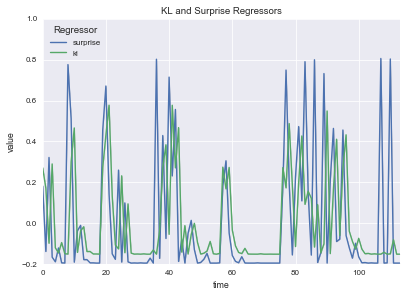

In [23]:
#load data
data = scipy.io.loadmat('model_accuracy.mat')
correct_answers = data['model_accuracy']
correct_answers = correct_answers[1:,:].ravel(order = 'F') #drop first entry because its NaN for KL
surprise = 1 - correct_answers
kl = data['kl_div']
kl = kl[1:,:].ravel(order = 'F')

#subtract means
surprise = surprise - np.mean(surprise)
kl = kl - np.nanmean(kl)

#plot
df_kl = {'Regressor':['surprise']*len(surprise) + ['kl']*len(kl), 'time':range(len(kl)) + range(len(kl)),
     'value': list(surprise) + list(kl), 'sub' : np.ones(2*len(kl))}
df_kl = pd.DataFrame(df_kl)
sns.tsplot(value = 'value', condition = 'Regressor', time = 'time', unit = 'sub',data = df_kl)
plt.savefig('../figures/kl_surprise')
plt.title('KL and Surprise Regressors')
print scipy.stats.pearsonr(surprise,kl)

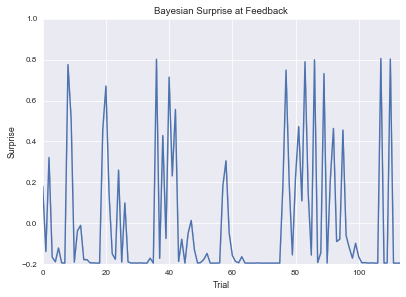

In [29]:
sns.tsplot(surprise)
plt.ylabel('Surprise')
plt.xlabel('Trial')
plt.title('Bayesian Surprise at Feedback')
plt.savefig(home_dir + '/figures/surprise.png',dpi = 600)

# Compute and plot the rule complexity

In [15]:
def count_and_or(in_str):
    count = 1
    count += in_str.count('and')
    count += in_str.count('or')
    return count

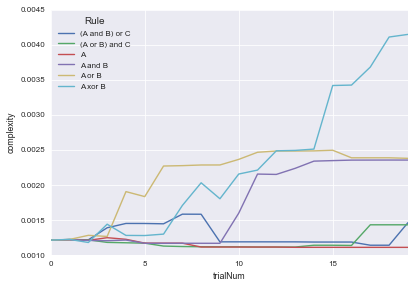

In [16]:
rule_map = {'AandB.txt':'A and B','AandB_orC.txt': '(A and B) or C','AxorB.txt':'A xor B',
           'A.txt':'A','AorB_andC.txt':'(A or B) and C', 'AorB.txt':'A or B'}
data = pd.read_csv('fit_renormalized.txt',delimiter = ' ')
data['Rule'] = [rule_map[x] for x in data['Rule'].values]
data = data.sort(['Rule'])
counts = map(count_and_or,data['hypothesis'].values)

data['complexity'] = np.array(counts * data['probrenormalized'].values).astype(float)
sns.tsplot(value='complexity',
           condition='Rule',
           time='trialNum',
           unit='hypNum', 
           data=data,
          err_style = None)
plt.savefig('../figures/complexity')

# Compute and plot the model entropy

In [123]:
def multinomial_entropy(d):
    entropy = 0
    for key in d.keys():
        entropy -= d[key] * math.log(d[key],2) #compute entropy in shannons
    return entropy

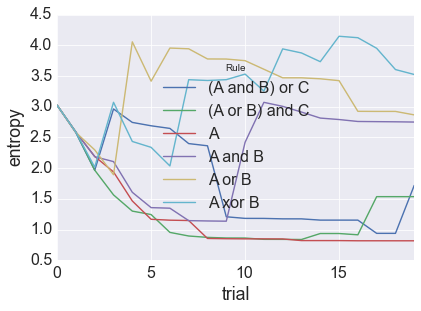

In [143]:
rules = list(set(data['Rule'].values))
entropies = []
for rule in rules:
    rule_df = data[data['Rule'] == rule]
    for trial in range(0,20):
        trial_df = rule_df[rule_df['trialNum'] == trial]
        probs = trial_df['probrenormalized'].values
        entropy = map(lambda x: x*np.log(x),probs) #compute entropy
        entropy = sum(entropy)*-1
        entropies.append(entropy)

condition = np.array(rules).repeat(20)
trial = range(20)*6
sub =[1]*(len(trial)) 

entropy_df = {'entropy':entropies, 'Rule': condition, 'trial': trial, 'sub':sub}
entropy_df = pd.DataFrame(entropy_df).sort(['Rule'])
sns.tsplot(value='entropy',
           condition='Rule',
           time='trial',
           unit='sub', 
           data=entropy_df)
plt.savefig('../figures/entropy')

# Simulate RL for best parameters of exhaustive model

In [102]:
alpha = 0.12774507
m = 1.377#2.75336711
state_rep = 'exhaustive'
return_LL = False
cond_list_ordered = ['A and B','(A and B) or C','A or B','A','A xor B','(A or B) and C']
out_map = {1:'Correct',-1:'Incorrect'}
outcomes_ordered = []
deltas = []

for sub in sub_list:
    sub_df = df[df['sub'] == sub]
    
    d = []
    for n,cond in enumerate(cond_list_ordered):
        c = sub_df[sub_df['condition'] == cond]
        states = np.array([c['a'].values,c['b'].values,c['c'].values])

        resp = c['resp'].values
        outcomes = c['hits'].values *2 -1
        true = c['true'].values *2 -1
        outcomes_ordered.extend(outcomes)
        
        pe = get_LL(alpha,m,states,resp,outcomes,true,state_rep,return_LL)
        d.append(pe)

    d = np.array(d)
    deltas.extend(d.ravel(order = 'C'))
    f = os.path.abspath('/Users/ianballard/Dropbox/rule_learning/mri_data/rule_learning_' + sub + '/rl_pe')
    np.savetxt(f,d.T)
outcomes_labels = [out_map[x] for x in outcomes_ordered]

# Examine PE and Surprise signals grouped by outcome valence

Ttest_indResult(statistic=47.222164411462202, pvalue=2.3332274548732144e-310)
r 0.755391936757 r squared 0.570616978118 t 2.33322745487e-310


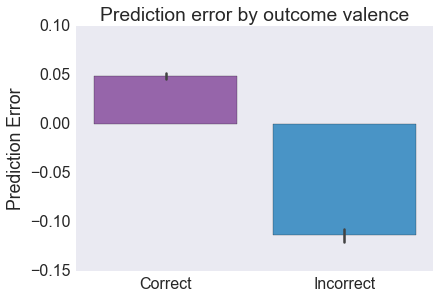

In [107]:
deltas = np.array(deltas)
pes = {'Reward Prediction Error': deltas,'outcome valence': outcomes_ordered, 'Outcome':outcomes_labels}
pes = pd.DataFrame(pes)

print scipy.stats.ttest_ind(pes[pes['outcome valence'] == 1]['Reward Prediction Error'].values,
                     pes[pes['outcome valence'] == -1]['Reward Prediction Error'].values)
r,t = scipy.stats.pearsonr(pes['Reward Prediction Error'].values,
                     pes['outcome valence'].values)
print 'r',r, 'r squared',r**2, 't',t
sns.barplot(y='Reward Prediction Error',x='Outcome', data=pes,palette = sns.color_palette(flatui))
plt.title('Prediction error by outcome valence')
plt.ylabel('Prediction Error')
plt.xlabel('')
plt.savefig('../figures/rpe_outcome',dpi = 600,bbox_inches='tight')

Ttest_indResult(statistic=-21.825634578567499, pvalue=3.6556622548225421e-93)
r -0.470227376505 r squared 0.221113785614 t 3.65566225482e-93


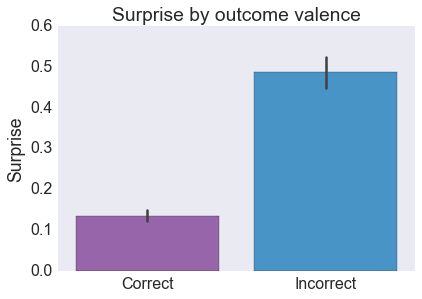

In [108]:
correct_answers = scipy.io.loadmat('model_accuracy.mat')
correct_answers = correct_answers['model_accuracy'].ravel(order = 'F')
correct_answers = 1-correct_answers

pes = {'Surprise': list(correct_answers)*len(sub_list),'outcome valence': outcomes_ordered,'Outcome':outcomes_labels}
pes = pd.DataFrame(pes)

print scipy.stats.ttest_ind(pes[pes['outcome valence'] == 1]['Surprise'].values,
                     pes[pes['outcome valence'] == -1]['Surprise'].values)
r,t = scipy.stats.pearsonr(pes['Surprise'].values,
                     pes['outcome valence'].values)
print 'r',r, 'r squared',r**2, 't',t
sns.barplot(y='Surprise',x='Outcome', data=pes,palette = sns.color_palette(flatui))
plt.title('Surprise by outcome valence')
plt.ylabel('Surprise')
plt.xlabel('')
plt.savefig('../figures/surprise_outcome', dpi = 600,bbox_inches='tight')

(-5.4794638018423507, 4.9508392829225921e-08)
r -0.135969584605 r squared 0.0184877279377 t 4.95083928292e-08


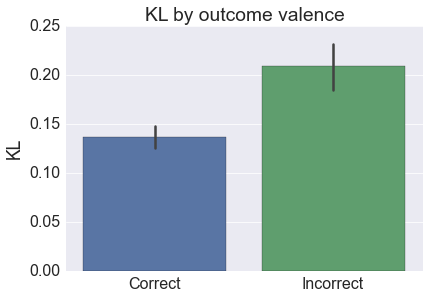

In [119]:
correct_answers = scipy.io.loadmat('model_accuracy.mat')
correct_answers = correct_answers['kl_div'].ravel(order = 'F')

pes = {'Surprise': list(correct_answers)*len(sub_list),'outcome valence': outcomes_ordered,'Outcome':outcomes_labels}
pes = pd.DataFrame(pes)
pes = pes.dropna()

print scipy.stats.ttest_ind(pes[pes['outcome valence'] == 1]['Surprise'].values,
                     pes[pes['outcome valence'] == -1]['Surprise'].values)
r,t = scipy.stats.pearsonr(pes['Surprise'].values,
                     pes['outcome valence'].values)
print 'r',r, 'r squared',r**2, 't',t
sns.barplot(y='Surprise',x='Outcome', data=pes)
plt.title('KL by outcome valence')
plt.ylabel('KL')
plt.xlabel('')
plt.savefig('../figures/KL_outcome', dpi = 600)

(-5.3392066009979402, 1.0610499280709812e-07)
r -0.129247655237 r squared 0.0167049563843 t 1.06104992807e-07


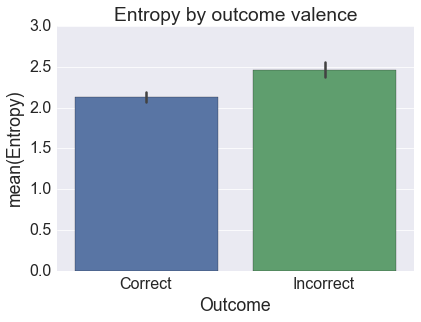

In [133]:
entropy_ordered = []
for c in cond_list_ordered:
    c_df = entropy_df[entropy_df['Rule'] == c]
    e = c_df.sort(['trial'])['entropy'].values
    entropy_ordered.extend(e)

    pes = {'Entropy': list(entropy_ordered)*len(sub_list),'outcome valence': outcomes_ordered,'Outcome':outcomes_labels}
pes = pd.DataFrame(pes)
pes = pes.dropna()

print scipy.stats.ttest_ind(pes[pes['outcome valence'] == 1]['Entropy'].values,
                     pes[pes['outcome valence'] == -1]['Entropy'].values)
r,t = scipy.stats.pearsonr(pes['Entropy'].values,
                     pes['outcome valence'].values)
print 'r',r, 'r squared',r**2, 't',t
sns.barplot(y='Entropy',x='Outcome', data=pes)

plt.title('Entropy by outcome valence')

In [146]:
entropy_diff = []
for c in cond_list_ordered:
    c_df = entropy_df[entropy_df['Rule'] == c]
    e = c_df.sort(['trial'])['entropy'].values

    e_diff = [np.NaN] #no diff for first trial
    for i in range(1,len(e)):
        diff = e[i] - e[i-1]
        e_diff.append(diff)
    entropy_diff.append(e_diff)

entropy_diff = np.array(entropy_diff).T
np.savetxt('entropy_diff.txt',entropy_diff)
entropy_diff = np.array(entropy_diff).ravel(order = 'F')

correct_answers = scipy.io.loadmat('model_accuracy.mat')
kl = correct_answers['kl_div'].ravel(order = 'F')
surprise = correct_answers['model_accuracy'].ravel(order = 'F')
surprise = 1 - surprise

surprise = [x for i,x in enumerate(surprise) if not np.isnan(kl[i])]
entropy_diff = [x for x in entropy_diff if not np.isnan(x)]
kl = [x for x in kl if not np.isnan(x)]
r,t = scipy.stats.pearsonr(kl, entropy_diff)
print r,t
r,t = scipy.stats.pearsonr(surprise, entropy_diff)
print r,t

0.208232813293 0.0261991992918
-0.0520403442473 0.582396085505


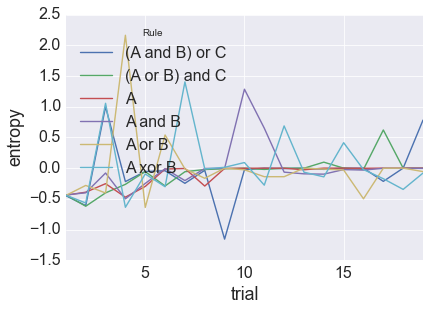

In [137]:
condition = np.array(cond_list_ordered).repeat(19)
trial = range(1,20)*6
sub =[1]*(len(trial)) 

entropy_df = {'entropy':entropy_diff, 'Rule': condition, 'trial': trial, 'sub':sub}
entropy_df = pd.DataFrame(entropy_df).sort(['Rule'])
sns.tsplot(value='entropy',
           condition='Rule',
           time='trial',
           unit='sub', 
           data=entropy_df)
plt.savefig('../figures/entropy_diff')